In [1]:
import torch
from torch import nn

import pandas as pd
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [40]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.Linear(10, 1),
            
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
model = BinaryClassifier().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

torch.manual_seed(42)
epochs = 2000
for epoch in range(epochs):
    model.train()
    
    # Forward Pass
    y_train_logits = model(X_train).squeeze()
    y_train_preds = torch.round(torch.sigmoid(y_train_logits))
    
    # Calculate loss
    train_loss = loss_fn(y_train_logits, y_train)
    
    optim.zero_grad()
    
    train_loss.backward()
    
    optim.step()
    
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test).squeeze()
        y_test_preds = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_score(y_test_preds, y_test)
        
    if epoch % 100 == 0:
        print(f'test loss: {test_loss}, test acc: {test_acc}')

test loss: 0.6907749772071838, test acc: 0.516
test loss: 0.6887218356132507, test acc: 0.556
test loss: 0.6858190298080444, test acc: 0.58
test loss: 0.6819847822189331, test acc: 0.568
test loss: 0.6766068339347839, test acc: 0.572
test loss: 0.668337881565094, test acc: 0.58
test loss: 0.655248761177063, test acc: 0.652
test loss: 0.6331680417060852, test acc: 0.74
test loss: 0.5904598832130432, test acc: 0.824
test loss: 0.5181279182434082, test acc: 0.952
test loss: 0.4095374643802643, test acc: 0.984
test loss: 0.2861171066761017, test acc: 1.0
test loss: 0.19242051243782043, test acc: 1.0
test loss: 0.13653047382831573, test acc: 1.0
test loss: 0.10375943779945374, test acc: 1.0
test loss: 0.08339163661003113, test acc: 1.0
test loss: 0.0698368027806282, test acc: 1.0
test loss: 0.060230229049921036, test acc: 1.0
test loss: 0.053121186792850494, test acc: 1.0
test loss: 0.04767268896102905, test acc: 1.0


## MultiClass Classification

Similar to above but will need to change outputs

Add in argmax

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


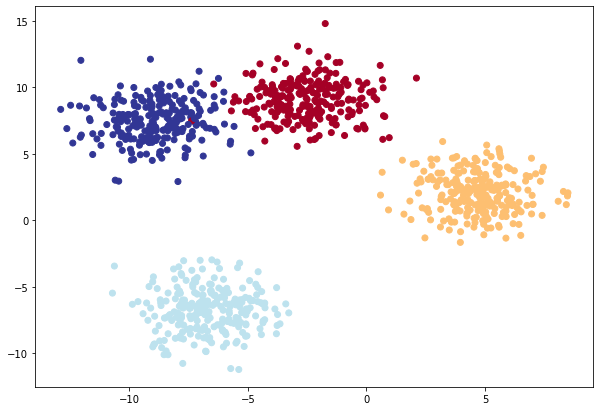

In [90]:
# Get Data
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [204]:
class MultiClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 4)
        )
        
    def forward(self, x: torch.tensor):
        logits = self.linear_stack(x)
        return logits

In [205]:
mc_model = MultiClass()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mc_model.parameters(), lr = 0.1)

In [206]:
def train_step(model, X_train, y_train, loss_fn, accuracy_score, optimizer):
    
    model.train()
    y_logits = model(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_score(y_preds, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
def test_step(model, X_test, y_test, loss_fn, accuracy_score, optimizer):
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_score(y_test_preds, y_test)
        
    if epoch % 100 == 0:
        print(f'epoch: {epoch}, loss: {test_loss}, accuracy, {test_acc}')
    

In [207]:
epochs = 1000
for epoch in range(epochs):
    train_step(mc_model, X_blob_train, y_blob_train, loss_fn, accuracy_score, optimizer)
    
    test_step(mc_model, X_blob_test, y_blob_test, loss_fn, accuracy_score, optimizer)

epoch: 0, loss: 1.5318412780761719, accuracy, 0.27
epoch: 100, loss: 0.024621019139885902, accuracy, 0.995
epoch: 200, loss: 0.016467131674289703, accuracy, 0.995
epoch: 300, loss: 0.014432618394494057, accuracy, 0.995
epoch: 400, loss: 0.013362031430006027, accuracy, 0.995
epoch: 500, loss: 0.012645937502384186, accuracy, 0.995
epoch: 600, loss: 0.01208256371319294, accuracy, 0.995
epoch: 700, loss: 0.011638598516583443, accuracy, 0.995
epoch: 800, loss: 0.01124832034111023, accuracy, 0.995
epoch: 900, loss: 0.010894992388784885, accuracy, 0.995
